In [20]:
import gym
import numpy as np
import collections
import random

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.initializers import normal, identity

import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

In [2]:
class SineEnv(gym.Env):
    
    def __init__(self, n=1000):
        
        self.n = n
        self.num_actions = 3
        self.series = 3 + np.sin(0.01* np.arange(self.n))
        self.done = False
        self.action_space = gym.spaces.Discrete(self.num_actions)
    
    def step(self, action):
        
        self.index += 1
        obs = self.series[self.index]
        step_return = np.log(self.series[self.index]/self.series[self.index-1])
        reward = (action - 1) * step_return
        
        if self.index >= (self.n-1):
            self.done = True
            
        info = {
            'return': step_return
        }
        return obs, reward, self.done, info
        
    def reset(self):
        self.index = 0
        self.done = False
        obs = self.series[self.index]
        return obs

In [17]:
class PolicyGradientAgent(object):
    
    def __init__(self, num_actions=3, replay_buffer_size=1000, sess=None, stack_size=8, l=96, n=10, train_period=20):
        
        self.num_actions = num_actions
        self.replay_buffer_size = replay_buffer_size
        self.stack_size = stack_size
        self._replay = collections.deque(maxlen=self.replay_buffer_size)
        self.train_period = train_period
        
        self.sess = sess
        
        self.series = []
        self.n = n
        
        self.steps = 0
        self.model = self._build_model()
        
        K.set_session(sess)



    def log_prob(self, state, action):
        p = K.log(self.model(state))
        p = K.slice(p, [action], [1])
        return p

    def _train_step(self):
        
        # Train whenever a multiple of train_period
        if ((self.steps % self.train_period) == 0) and ((len(self._replay)) > self.n):
            
            minibatch = random.sample(self._replay, self.n)
            
            inputs = []
            for (state, action, reward) in minibatch:
                inputs.append(state)
                print("Type of list converted to numpy array: {}".format(type(np.array(inputs))))
                
            inputs_tensor = tf.convert_to_tensor(np.array(inputs))
            labels = self.model(inputs_tensor)
            model.fit(inputs, labels, epochs=1)
                
    def loss_function(self):
        loss = self.model(input_tensors)
        -(loss[action] * reward)
        
        

    def _build_model(self):
        
        inputs = Input(shape=(self.stack_size,))
        X = Dense(64, activation='relu')(inputs)
        X = Dense(64, activation='relu')(X)
        predictions = Dense(self.num_actions, activation='softmax')(X)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=SGD(), loss='mse')
        
        return model
    
    def initialise_episode(self, observation):
        self.series.extend([observation] * self.stack_size)
        self.state = self.construct_state(observation)
        return self._select_action(self.state)
    
    def construct_state(self, observation):
        self.series.append(observation)
        log_ret = np.log((np.array(self.series[1:]))/(np.array(self.series[:-1])))
        return log_ret[-self.stack_size:]
    
    def step(self, reward, observation):
        self.current_state = self.construct_state(observation)
        experience = (self.state, self.action, reward)
        self._replay.append(experience)
        self.state = self.current_state
        self.steps += 1
        
        # Train the model
        self._train_step()
        return self._select_action(self.state)
    
    def _select_action(self, state):
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.reshape(state_tensor, shape=(1, self.stack_size))

        action_prob_values = K.eval(self.model(state_tensor))
        print("Action prob values: {}".format(action_prob_values))
        self.action = np.random.choice(a=np.arange(self.num_actions), p=action_prob_values[0])
        return self.action

In [18]:
env = SineEnv(n=1000)

sess = tf.Session()

agent = PolicyGradientAgent(sess=sess)

In [19]:
obs = env.reset()
done = False

observations = []
action = agent.initialise_episode(obs)

agent_rewards = []
benchmark_rewards = []

while not done:
    obs, reward, done, info = env.step(action)
    agent_rewards.append(reward)
    benchmark_rewards.append(info['return'])
    if not done:
        action = agent.step(reward, obs)

Action prob values: [[0.33333334 0.33333334 0.33333334]]
Action prob values: [[0.33346388 0.33310786 0.3334283 ]]
Action prob values: [[0.33340696 0.3328473  0.33374572]]
Action prob values: [[0.3334378  0.33268356 0.33387867]]
Action prob values: [[0.33343917 0.3327071  0.33385372]]
Action prob values: [[0.33353686 0.33247826 0.33398488]]
Action prob values: [[0.3335175  0.3324737  0.33400878]]
Action prob values: [[0.3335742  0.33245406 0.33397168]]
Action prob values: [[0.33343214 0.3326349  0.33393297]]
Action prob values: [[0.33343175 0.33263764 0.3339306 ]]
Action prob values: [[0.33343133 0.33264047 0.33392823]]
Action prob values: [[0.33343092 0.3326433  0.33392578]]
Action prob values: [[0.33343047 0.3326462  0.3339233 ]]
Action prob values: [[0.33343005 0.33264914 0.3339208 ]]
Action prob values: [[0.3334296  0.33265212 0.33391824]]
Action prob values: [[0.3334292  0.33265522 0.33391568]]
Action prob values: [[0.3334287  0.33265826 0.333913  ]]
Action prob values: [[0.3334282

Action prob values: [[0.33334216 0.33326158 0.3333962 ]]
Action prob values: [[0.33334142 0.33326697 0.33339164]]
Action prob values: [[0.33334062 0.33327234 0.33338705]]
Action prob values: [[0.33333984 0.33327764 0.33338252]]
Action prob values: [[0.3333391  0.33328295 0.33337796]]
Action prob values: [[0.33333832 0.33328834 0.33337337]]
Action prob values: [[0.33333752 0.33329374 0.33336872]]
Action prob values: [[0.3333367  0.333299   0.33336428]]
Action prob values: [[0.33333585 0.33330396 0.3333602 ]]
Action prob values: [[0.33333495 0.33330876 0.33335626]]
Action prob values: [[0.33333415 0.33331352 0.33335236]]
Action prob values: [[0.3333333 0.3333181 0.3333486]]
Action prob values: [[0.33333236 0.33332172 0.3333459 ]]
Action prob values: [[0.3333322  0.33332482 0.3333429 ]]
Action prob values: [[0.33333367 0.33332667 0.33333966]]
Action prob values: [[0.33333585 0.33332682 0.3333373 ]]
Action prob values: [[0.3333372  0.3333284  0.33333442]]
Action prob values: [[0.33333868 0

Action prob values: [[0.33345994 0.33320886 0.33333123]]
Action prob values: [[0.33346063 0.3332081  0.33333126]]
Action prob values: [[0.33346128 0.3332074  0.3333313 ]]
Action prob values: [[0.33346197 0.3332067  0.33333132]]
Action prob values: [[0.33346263 0.333206   0.33333135]]
Action prob values: [[0.33346328 0.3332053  0.33333138]]
Action prob values: [[0.33346394 0.33320466 0.33333144]]
Action prob values: [[0.33346456 0.33320397 0.33333144]]
Action prob values: [[0.33346522 0.33320335 0.3333315 ]]
Action prob values: [[0.3334658  0.33320263 0.33333153]]
Action prob values: [[0.3334664  0.33320197 0.33333153]]
Action prob values: [[0.33346707 0.33320138 0.3333316 ]]
Action prob values: [[0.33346763 0.33320072 0.3333316 ]]
Action prob values: [[0.33346823 0.33320013 0.33333167]]
Action prob values: [[0.3334688 0.3331995 0.3333317]]
Action prob values: [[0.33346936 0.33319888 0.33333173]]
Action prob values: [[0.33346993 0.3331983  0.3333318 ]]
Action prob values: [[0.3334705  0

Action prob values: [[0.33340746 0.33325312 0.33333942]]
Action prob values: [[0.33340567 0.33325487 0.33333945]]
Action prob values: [[0.33340386 0.33325663 0.33333948]]
Action prob values: [[0.33340207 0.33325842 0.33333954]]
Action prob values: [[0.33340022 0.3332602  0.33333957]]
Action prob values: [[0.33339834 0.333262   0.33333957]]
Action prob values: [[0.3333965  0.33326384 0.33333963]]
Action prob values: [[0.33339462 0.3332657  0.33333966]]
Action prob values: [[0.33339274 0.3332676  0.33333972]]
Action prob values: [[0.33339083 0.33326945 0.33333975]]
Action prob values: [[0.3333889  0.33327132 0.33333978]]
Action prob values: [[0.33338696 0.33327326 0.3333398 ]]
Action prob values: [[0.333385   0.33327514 0.3333398 ]]
Action prob values: [[0.33338302 0.33327708 0.3333398 ]]
Action prob values: [[0.33338106 0.33327916 0.33333978]]
Action prob values: [[0.33337906 0.33328122 0.33333972]]
Action prob values: [[0.33337706 0.3332833  0.3333397 ]]
Action prob values: [[0.3333750

Action prob values: [[0.33343816 0.3325906  0.33397123]]
Action prob values: [[0.3334384 0.3325889 0.3339727]]
Action prob values: [[0.33343863 0.33258733 0.3339741 ]]
Action prob values: [[0.3334388  0.33258578 0.33397534]]
Action prob values: [[0.33343902 0.3325844  0.33397657]]
Action prob values: [[0.3334392  0.3325831  0.33397767]]
Action prob values: [[0.33343938 0.33258194 0.33397874]]
Action prob values: [[0.33343953 0.3325808  0.33397967]]
Action prob values: [[0.33343968 0.3325798  0.33398053]]
Action prob values: [[0.33343983 0.33257887 0.3339813 ]]
Action prob values: [[0.33343992 0.33257803 0.333982  ]]
Action prob values: [[0.33344007 0.3325773  0.33398262]]
Action prob values: [[0.33344018 0.3325767  0.33398318]]
Action prob values: [[0.33344024 0.33257613 0.33398363]]
Action prob values: [[0.3334403  0.33257562 0.333984  ]]
Action prob values: [[0.3334404  0.3325753  0.33398432]]
Action prob values: [[0.33344042 0.332575   0.33398452]]
Action prob values: [[0.33344048 0

Action prob values: [[0.3333806  0.33299232 0.33362705]]
Action prob values: [[0.33337986 0.33299735 0.3336227 ]]
Action prob values: [[0.33337918 0.33300245 0.33361837]]
Action prob values: [[0.33337843 0.33300754 0.33361402]]
Action prob values: [[0.33337772 0.3330126  0.33360964]]
Action prob values: [[0.333377   0.33301774 0.3336053 ]]
Action prob values: [[0.33337626 0.33302283 0.3336009 ]]
Action prob values: [[0.33337554 0.33302796 0.33359653]]
Action prob values: [[0.3333748  0.33303308 0.33359212]]
Action prob values: [[0.33337405 0.33303824 0.3335877 ]]
Action prob values: [[0.3333733  0.33304337 0.3335833 ]]
Action prob values: [[0.3333726  0.33304855 0.33357888]]
Action prob values: [[0.33337185 0.33305374 0.33357447]]
Action prob values: [[0.33337107 0.33305886 0.33357   ]]
Action prob values: [[0.33337036 0.33306408 0.3335656 ]]
Action prob values: [[0.3333696  0.33306924 0.33356112]]
Action prob values: [[0.33336887 0.33307445 0.33355668]]
Action prob values: [[0.3333681

Action prob values: [[0.33341688 0.3332531  0.33333007]]
Action prob values: [[0.3334178  0.3332521  0.33333004]]
Action prob values: [[0.33341876 0.33325115 0.33333007]]
Action prob values: [[0.33341968 0.3332502  0.33333007]]
Action prob values: [[0.33342063 0.3332492  0.3333301 ]]
Action prob values: [[0.33342156 0.3332483  0.3333301 ]]
Action prob values: [[0.3334225  0.33324733 0.33333015]]
Action prob values: [[0.33342344 0.3332464  0.33333015]]
Action prob values: [[0.33342436 0.33324546 0.33333018]]
Action prob values: [[0.33342528 0.3332445  0.33333018]]
Action prob values: [[0.33342618 0.33324355 0.33333018]]
Action prob values: [[0.3334271  0.33324262 0.3333302 ]]
Action prob values: [[0.33342803 0.33324173 0.33333024]]
Action prob values: [[0.33342895 0.33324084 0.3333303 ]]
Action prob values: [[0.33342984 0.33323988 0.3333303 ]]
Action prob values: [[0.33343074 0.33323896 0.3333303 ]]
Action prob values: [[0.33343163 0.33323804 0.33333033]]
Action prob values: [[0.3334325

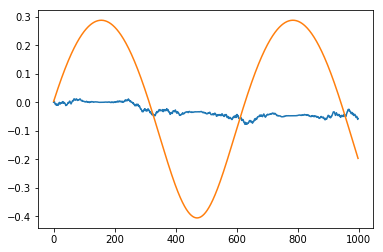

In [68]:
plt.plot(np.cumsum(agent_rewards))
plt.plot(np.cumsum(benchmark_rewards))

In [67]:
agent_rewards

[0.0,
 0.003316366504332892,
 0.0,
 -0.00329287248224624,
 -0.0032807539279420604,
 -0.0032683924580139976,
 0.0,
 0.0,
 -0.0032298858318851437,
 0.0032165878111498707,
 0.0,
 -0.003189318567616955,
 0.0,
 0.0,
 0.0031467818413767564,
 -0.0031321806349846053,
 0.00311737365092575,
 0.003102364060013224,
 0.0,
 0.0030717495675277174,
 -0.0030561508341639928,
 -0.003040361830362619,
 0.003024385553510366,
 0.0,
 0.0,
 0.0,
 0.0029586664525747012,
 -0.0029417975615126063,
 0.00292475865698327,
 0.0,
 0.0028901818002611264,
 -0.002872649259740262,
 0.0,
 -0.002837109231115252,
 0.002819106953446421,
 -0.0028009532518951706,
 0.0,
 0.0,
 -0.0027456086668977133,
 -0.0027268741702648376,
 -0.0027080005382589287,
 0.0026889901323595075,
 0.0,
 0.0,
 0.0,
 0.0026116269017221576,
 0.0025919669544558527,
 0.00257218374937059,
 0.0,
 -0.0025322561215376667,
 0.002512115902876299,
 0.0024918608351444252,
 0.002471492947875931,
 0.0,
 -0.002430426690799959,
 -0.0024097322388941774,
 -0.0023889328038

In [106]:
np.random.choice(np.arange(3), p=np.array([0.2, 0.6, 0.2]))

1

In [122]:
ar1 = np.arange(10)
ar1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [118]:
ar2 = np.arange(2,7)
ar2

array([2, 3, 4, 5, 6])

In [123]:
ar1[1:]/ar1[:-1]

/Users/sushantkumar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


array([       inf, 2.        , 1.5       , 1.33333333, 1.25      ,
       1.2       , 1.16666667, 1.14285714, 1.125     ])

In [124]:
l1 = [1,2]

In [142]:
np.array(l1)

some_tensor = tf.convert_to_tensor(np.arange(8), dtype=tf.float32)

In [148]:
reshaped_tensor = tf.reshape(some_tensor, shape=(1,8))

In [149]:
agent.model(reshaped_tensor)

<tf.Tensor 'model_14_4/dense_42/Softmax:0' shape=(1, 3) dtype=float32>

In [158]:
np.random.randn(2,8).shape

(2, 8)

In [22]:
np.empty(3)

array([0.e+000, 5.e-324, 1.e-323])